In [2]:
#Salary league Analysis
#Ed Costantini - costed12@gmail.com
#Optimizing salary league performance given projections and salary costs


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#importing files
#hitter and pitcher projections taken from steamer
#fantrax silver csv file provides salaries for the relevant league
#hit,pit,fan = 'steamerhitter','steamerpitcher','fantraxsilver'
hit,pit,fan = 'atchitter','atcpitcher','fantraxsilver'
fileHit = hit + '.csv'
filePit = pit +'.csv'
fileFan = fan + '.csv'

In [4]:
#import Hitter and Pitcher Stats
dfIn = pd.read_csv(fileHit)
dfIn.rename(columns={ dfIn.columns[0]: "PlayerName" },inplace=True)

#drop everyone with <400 PA
dfIn=dfIn.loc[(dfIn['PA'] >= 400)]
dfHitterProj=dfIn

#create pts column
dfIn=dfIn.rename(index=str, columns={"2B": "double", "3B": "triple"})

#This is the objective hitters points function defined by your league. 
dfIn['PTS']=dfIn.apply(lambda row: row.H+row.double+2*row.triple+3*row.HR
                       +row.BB+row.R+row.RBI+row.HBP+2*row.SB,axis=1)

dfIn = dfIn.loc[:,['PlayerName','Team','PTS']]
dfIn.head()


,PlayerName,Team,PTS
0,Mike Trout,Angels,710.0
1,Joey Votto,Reds,644.0
2,Freddie Freeman,Braves,621.0
3,Bryce Harper,Nationals,594.0
4,Giancarlo Stanton,Yankees,608.0


In [5]:
dfInP = pd.read_csv(filePit)
dfInP.rename(columns={ dfInP.columns[0]: "PlayerName" },inplace=True)

#drop everyone with <50 IP
dfInP=dfInP.loc[(dfInP['IP'] >= 50)]
dfPitcherProj=dfInP

#create pts column
#This is the objective pitcher points 
dfInP['PTS']=dfInP.apply(lambda row: row.IP+row.SO+10*row.W+10*row.SV,axis=1)

dfInP = dfInP.loc[:,['PlayerName','Team','PTS']]
dfInP.head()

,PlayerName,Team,PTS
0,Kenley Jansen,Dodgers,605.0
2,Craig Kimbrel,Red Sox,586.0
3,A.J. Minter,Braves,200.0
4,Andrew Miller,Indians,282.0
5,Noah Syndergaard,Mets,459.0


In [6]:
#append into single df
dfIn = dfIn.append(dfInP)
dfIn = dfIn.loc[:,['PlayerName','Team','PTS']]

In [7]:
dfInF = pd.read_csv(fileFan)
dfInF.rename(columns={ dfIn.columns[0]: "PlayerNameBad" },inplace=True)

#change playername formatting
dfInF['PlayerName'] = dfInF['PlayerNameBad'].str.split(', ').str[::-1].str.join(' ')
dfInF = dfInF.loc[:,['PlayerName','POS','Salary']]

df=dfIn.merge(dfInF, on='PlayerName', how='left')
df=df.dropna().copy()
df.head()

,PlayerName,Team,PTS,POS,Salary
0,Mike Trout,Angels,710.0,"OF,UT",3280000.0
1,Joey Votto,Reds,644.0,"1B,UT",3030000.0
2,Freddie Freeman,Braves,621.0,"1B,UT",2820000.0
3,Bryce Harper,Nationals,594.0,"OF,UT",2850000.0
4,Giancarlo Stanton,Yankees,608.0,"OF,UT",2930000.0


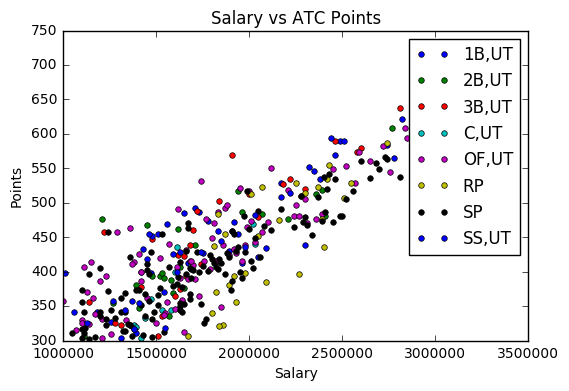

In [23]:
#Visualization

dfPlot= df[df['PTS'] > 300] 
groups = dfPlot.groupby('POS')


# Plot 
fig, ax = plt.subplots()
for name, group in groups:    
    ax.plot(group.Salary, group.PTS, marker='o', linestyle='', ms=4, label=name)
ax.legend()

ax.set_title('Salary vs ATC Points')
ax.set_xlabel('Salary')
ax.set_ylabel('Points')
plt.show()

In [8]:
#get player
def getPlayer(playerName):
    return (df.loc[df['PlayerName']==playerName])

In [9]:
#get player
def getHitterProj(playerName):
    return (dfHitterProj.loc[dfHitterProj['PlayerName']==playerName])

In [10]:
#get player
def getPitcherProj(playerName):
    return (dfPitcherProj.loc[dfPitcherProj['PlayerName']==playerName])

In [11]:
#add hitter to team
def addPlayer(playerNames,team):
    for i in range(len(playerNames)):
        name=playerNames[i]
        team=team.append(getPlayer(name))
    return team

In [12]:
#remove player from team
def dropPlayer(playerName,team):
    target=team.loc[team['PlayerName']==playerName]
    team=team.drop(target)
    return team


In [18]:
myTeam=pd.DataFrame()

In [19]:
#jose ramirez fix
#manually setting jose ramirez RP's value
df.loc[(df['PlayerName'] == 'Jose Ramirez') & (df['POS'].str.contains('P')), 'PTS'] = -9.2

In [20]:
import pulp

In [21]:
def lineupOptimizer(df):
    # initialize variables
    playerPositions = df['POS'].tolist()
    playerNames = df['PlayerName'].tolist()
    playerCosts = tuple(df['Salary']) #using salary costs
    playerPoints = tuple(df['PTS'])
    
    salaryCap = 60*1000000 #60 mil
    numOfPlayers = range(len(playerCosts))
    
    # formulate linear programming problem
    problem = pulp.LpProblem("Optimal Lineup", pulp.LpMaximize)
    # create variable to represent each player
    playerInLineup = pulp.LpVariable.dicts("Players", [i for i in numOfPlayers], 0, 1, cat="Binary")
    # create objective: maximize sum of player points
    problem += pulp.lpSum(playerInLineup[i] * playerPoints[i] for i in numOfPlayers)
    
    # constraint: each player can only be chosen at most once
    for i in numOfPlayers:
        problem += pulp.lpSum(playerInLineup[i]) <= 1
    # constraints: sum of player costs must be less than or equal to the salary cap
    problem += sum(playerInLineup[i] * playerCosts[i] for i in numOfPlayers) <= salaryCap
    # constraint: teams must have 28 players
    problem += pulp.lpSum(problem.variables()) == 28
    
    #add players from my team
    if(len(myTeam)>0):
        keep = tuple(myTeam['Salary']>0)
        problem += pulp.lpSum(playerInLineup[i] * keep[i] for i in numOfPlayers) == sum(keep)

    # position al consrtaints
    # constraint: 2 <= C
    #catchers = tuple(df['Pos'] == 'C')
    catchers = tuple(df['POS'].str.contains('C'))
    problem += pulp.lpSum(playerInLineup[i] * catchers[i] for i in numOfPlayers) >= 2

    # constraint: 2 <= number of 1b
    fb = tuple(df['POS'].str.contains('1B'))
    problem += pulp.lpSum(playerInLineup[i] * fb[i] for i in numOfPlayers) >= 2

    # constraint: 2 <= number of 2b
    sb = tuple(df['POS'].str.contains('2B'))
    problem += pulp.lpSum(sb[i] * playerInLineup[i] for i in numOfPlayers) >= 2

    # constraint: 2 <= number of 3b
    tb = tuple(df['POS'].str.contains('3B'))
    problem += pulp.lpSum(tb[i] * playerInLineup[i] for i in numOfPlayers) >= 2

    # constraint: 2 <= number of SS
    ss = tuple(df['POS'].str.contains('SS'))
    problem += pulp.lpSum(playerInLineup[i] * ss[i] for i in numOfPlayers) >= 2
    
    # constraint: 6 <= number of OF
    of = tuple(df['POS'].str.contains('OF'))
    problem += pulp.lpSum(playerInLineup[i] * of[i] for i in numOfPlayers) >= 6
    
    # constraint: 18 <= number of Total Players/UT
    ut = tuple(df['POS'].str.contains('UT'))
    problem += pulp.lpSum(playerInLineup[i] * ut[i] for i in numOfPlayers) >= 18
    
    # constraint: 6 <= number of SP
    sp = tuple(df['POS'].str.contains('SP'))
    problem += pulp.lpSum(playerInLineup[i] * sp[i] for i in numOfPlayers) >= 6
    
    #constraint: 4 <= number of RP
    rp = tuple(df['POS'].str.contains('RP'))
    problem += pulp.lpSum(playerInLineup[i] * rp[i] for i in numOfPlayers) >= 4
    
    # constraint: 10 <= number of P
    p = tuple(df['POS'].str.contains('P'))
    problem += pulp.lpSum(playerInLineup[i] * p[i] for i in numOfPlayers) >= 10
    
     
    # output the calculated predicted lineup
    cost = 0
    points = 0

    predicted = list()
    if problem.solve() == 1:
        for pos in range(len(numOfPlayers)):
            if playerInLineup[pos].value() == 1:
                name = playerNames[pos]
                predicted.append(name)
                cost += playerCosts[pos]
                points += playerPoints[pos]
                
                print ('%25s, Position = %2s, Price = %5.f, Points = %3.2f' \
                      % (playerNames[pos], playerPositions[pos], playerCosts[pos],
                         playerPoints[pos]))
        print ('\nTotal Team Cost: %5d\nTotal Team Points: %5.2f' % (cost, points))
        
    else:
        print ('Error finding solution')
        
    return(predicted,cost,points)

In [16]:
# def salaryOptimizer(df,playerName,pointsMax):
# This can be used in salary + draft leagues, not necessary for these current league settings
#     # initialize variables
#     playerPositions = df['POS'].tolist()
#     playerNames = df['PlayerName'].tolist()
#     playerCosts = tuple(df['Salary']) #using salary costs
#     playerPoints = tuple(df['PTS'])
    
#     salaryCap = 60*1000000 #60 mil
#     numOfPlayers = range(len(playerCosts))
    
#     # formulate linear programming problem
#     problem = pulp.LpProblem("Optimal Salary", pulp.LpMaximize)
#     # create variable to represent each player
#     playerInLineup = pulp.LpVariable.dicts("Players", [i for i in numOfPlayers], 0, 1, cat="Binary")
#     targetCost= pulp.LpVariable("TC")
        
#     # create objective: maximize player 'adjusted' while including him in optimal lineup
#     problem+=targetCost
    
#     #constraint: our player needs to be in the lineup
#     target = tuple(df['PlayerName']==playerName)
#     problem += pulp.lpSum(playerInLineup[i] * target[i] for i in numOfPlayers) == 1
    
#     #constraint: points needs to be >= last value
#     problem += pulp.lpSum(playerInLineup[i] * playerPoints[i] for i in numOfPlayers) >= pointsMax-1
    
#     # constraint: each player can only be chosen at most once
#     for i in numOfPlayers:
#         problem += pulp.lpSum(playerInLineup[i]) <= 1
#     # constraints: sum of player costs must be less than or equal to the salary cap
#     problem += sum(playerInLineup[i] * playerCosts[i] for i in numOfPlayers) <= salaryCap-targetCost
#     # constraint: teams must have 28 players
    
#     badCode = tuple(df['PlayerName'].notnull())
#     problem += pulp.lpSum(playerInLineup[i] * badCode[i] for i in numOfPlayers) == 28 #of players in lineup
    
#     #add players from my team
#     if(len(myTeam)>0):
#         keep = tuple(myTeam['Salary']>0) #this wont work
#         problem += pulp.lpSum(playerInLineup[i] * keep[i] for i in numOfPlayers) == sum(keep)

#     # positions
#     # constraint: 2 <= C
#     #catchers = tuple(df['Pos'] == 'C')
#     catchers = tuple(df['POS'].str.contains('C'))
#     problem += pulp.lpSum(playerInLineup[i] * catchers[i] for i in numOfPlayers) >= 2

#     # constraint: 2 <= number of 1b
#     fb = tuple(df['POS'].str.contains('1B'))
#     problem += pulp.lpSum(playerInLineup[i] * fb[i] for i in numOfPlayers) >= 2

#     # constraint: 2 <= number of 2b
#     sb = tuple(df['POS'].str.contains('2B'))
#     problem += pulp.lpSum(sb[i] * playerInLineup[i] for i in numOfPlayers) >= 2

#     # constraint: 2 <= number of 3b
#     tb = tuple(df['POS'].str.contains('3B'))
#     problem += pulp.lpSum(tb[i] * playerInLineup[i] for i in numOfPlayers) >= 2

#     # constraint: 2 <= number of SS
#     ss = tuple(df['POS'].str.contains('SS'))
#     problem += pulp.lpSum(playerInLineup[i] * ss[i] for i in numOfPlayers) >= 2
    
#     # constraint: 6 <= number of OF
#     of = tuple(df['POS'].str.contains('OF'))
#     problem += pulp.lpSum(playerInLineup[i] * of[i] for i in numOfPlayers) >= 6
    
#     # constraint: 18 <= number of UT
#     ut = tuple(df['POS'].str.contains('UT'))
#     problem += pulp.lpSum(playerInLineup[i] * ut[i] for i in numOfPlayers) >= 18
    
#     # constraint: 6 <= number of SP
#     sp = tuple(df['POS'].str.contains('SP'))
#     problem += pulp.lpSum(playerInLineup[i] * sp[i] for i in numOfPlayers) >= 6
    
#     #constraint: 4 <= number of RP
#     rp = tuple(df['POS'].str.contains('RP'))
#     problem += pulp.lpSum(playerInLineup[i] * rp[i] for i in numOfPlayers) >= 4
    
#     # constraint: 10 <= number of P
#     p = tuple(df['POS'].str.contains('P'))
#     problem += pulp.lpSum(playerInLineup[i] * p[i] for i in numOfPlayers) >= 10
    
     
#     # output the calculated predicted lineup
#     cost = 0
#     points = 0

#     predicted = list()
#     if problem.solve() == 1:
#         for pos in range(len(numOfPlayers)):
#             if playerInLineup[pos].value() == 1:
#                 name = playerNames[pos]
#                 predicted.append(name)
#                 cost += playerCosts[pos]
#                 points += playerPoints[pos]
                
#                 print ('%25s, Position = %2s, Price = %5.f, Points = %3.2f' \
#                       % (playerNames[pos], playerPositions[pos], playerCosts[pos],
#                          playerPoints[pos]))
#         print ('\nTotal Team Cost: %5d\nTotal Team Points: %5.2f' % (cost, points))
#         print (playerName, targetCost.value())
        
#     else:
#         print ('Error finding solution')
        
#     return (predicted,cost,points,targetCost)

In [22]:
predictedLineup, cost, maxPoints = lineupOptimizer(df)


               Mike Trout, Position = OF,UT, Price = 3280000, Points = 710.00
         Paul Goldschmidt, Position = 1B,UT, Price = 3240000, Points = 663.00
              Kris Bryant, Position = 3B,UT, Price = 2810000, Points = 637.00
             Jose Ramirez, Position = 3B,UT, Price = 2460000, Points = 589.00
             Rhys Hoskins, Position = OF,UT, Price = 1740000, Points = 531.00
             Gary Sanchez, Position = C,UT, Price = 2020000, Points = 469.00
           Cody Bellinger, Position = 1B,UT, Price = 2490000, Points = 589.00
        Willson Contreras, Position = C,UT, Price = 1610000, Points = 436.00
             Mookie Betts, Position = OF,UT, Price = 2890000, Points = 630.00
             Alex Bregman, Position = 3B,UT, Price = 1910000, Points = 569.00
             Brian Dozier, Position = 2B,UT, Price = 2770000, Points = 609.00
         Francisco Lindor, Position = SS,UT, Price = 2510000, Points = 590.00
              Trea Turner, Position = SS,UT, Price = 2440000, Poin

In [24]:
#statcost determination under each system
df['DollarPts'] = df['Salary']/df['PTS']

In [25]:
#display top 1b
dfFB= df[df['POS'].str.contains('1B')]
dfFB = dfFB.sort_values('Salary',ascending = False)
#dfFB.head(30)

In [26]:
dfSB= df[df['POS'].str.contains('2B')]
#dfSB.head(15)

In [27]:
dfTB= df[df['POS'].str.contains('3B')]
#dfTB.head(15)

In [28]:
dfSS= df[df['POS'].str.contains('SS')] #Lindor, Trea Turner
#dfSS.head(15)

In [29]:
dfOF= df[df['POS'].str.contains('OF')]
dfOF=dfOF.sort_values('PTS',ascending = False)
#dfOF.head(60)

In [30]:
dfUT = df[df['POS'].str.contains('UT')]
dfUT = dfUT[dfUT['Salary']<1400000]
dfUT =dfUT.sort_values('PTS',ascending = False)
#dfUT.head(40)

In [31]:
dfSP = df[df['POS'].str.contains('SP')]
dfSP = dfSP.sort_values('Salary',ascending = False) 
dfSP=dfSP.loc[:,['PlayerName','Team','PTS','Salary']]
#dfSP.head(80)

In [32]:
dfRP = df[df['POS'].str.contains('RP')]
dfRP = dfRP.sort_values('PTS',ascending = False) 
            #Chris Sale, Position = SP, Price = 3250000, Points = 650.00
#                 Brad Hand, Position = RP, Price = 2010000, Points = 513.00
#                Aaron Nola, Position = SP, Price = 1990000, Points = 517.00
#               Luke Weaver, Position = SP, Price = 1240000, Points = 458.00
#                  Jon Gray, Position = SP, Price = 1670000, Points = 464.00
#               Zack Godley, Position = SP, Price = 1530000, Points = 455.00
#              Jose Berrios, Position = SP, Price = 1670000, Points = 471.00
dfRP=dfRP.loc[:,['PlayerName','Team','PTS','Salary']]
#dfRP.head(30)

In [ ]:
#export analysis results to CSV file
dfSP.to_csv('FantraxSilverSP.csv')